# modesto tutorial

This tutorial shows how to let modesto solve a simple network.

## Imports and other stuff

In [1]:
from __future__ import division

import logging
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import modesto.utils as ut
from modesto.main import Modesto

In [2]:
%matplotlib notebook

In [3]:
logging.basicConfig(level=logging.WARNING,
                    format='%(asctime)s %(name)-36s %(levelname)-8s %(message)s',
                    datefmt='%m-%d %H:%M')
logger = logging.getLogger('Main.py')

## Network graph

A first step is to make a networkX object of the network you would like to optimize:

For the model to load correctly into modesto, you need to add some attributes to each of the nodes and edges.

For the nodes (besides the name of the node):
* **x, y, and z**: coordinates of the node in meter
* **comps**: a dictionary containing all components (except the network pipes) that are connected to the nodes. The keys of the dictionary are the names of the components, the values are the types of the components.

For the edges (besides names of the nodes where the edge starts and stops):
* **Name of the edge**
    

<IPython.core.display.Javascript object>


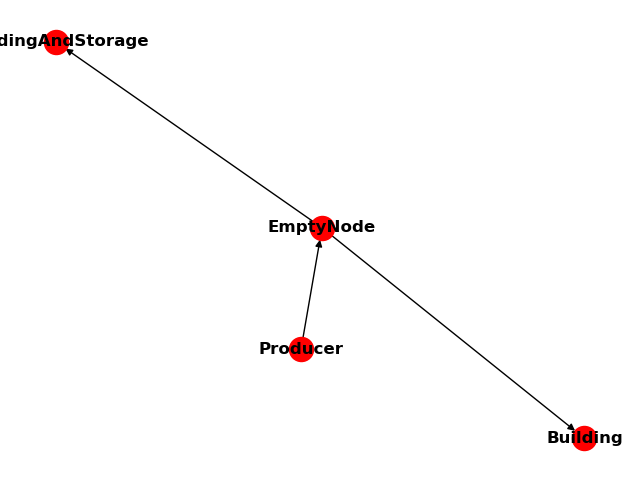

In [4]:
G = nx.DiGraph()

G.add_node('Producer', x=4000, y=4000, z=0,
           comps={'plant': 'ProducerVariable'})
G.add_node('EmptyNode', x=2600, y=5000, z=0,
           comps={})
G.add_node('BuildingAndStorage', x=2500, y=4600, z=0,
           comps={'building': 'RCmodel',
                  'storage': 'StorageVariable'
                  }
           )
G.add_node('Building', x=2000, y=5500, z=0,
           comps={'building': 'RCmodel'})

G.add_edge('Producer', 'EmptyNode', name='pipe1')
G.add_edge('EmptyNode', 'BuildingAndStorage', name='pipe2')
G.add_edge('EmptyNode', 'Building', name='pipe3')
    
nx.draw(G, with_labels=True, font_weight='bold')

## Setting up modesto

Decide the following characteristics of the optimization problem:
* **Horizon** of the optimization problem (in seconds)
* **Time step** of the (discrete) problem (in seconds)
* **Start time** (should be a pandas TimeStamp). Currently, weather and prixe data for 2014 are available in modesto.
* **Pipe model**: The type of model used to model the pipes. Only one type can be selected for the whole optimization problem (unlike the component model types). Possibilities: SimplePipe (= perfect pipe, no losses, no time delays), ExtensivePipe (limited mass flows and heat losses, no time delays) and NodeMethod (heat losses and time delays, but requires mass flow rates to be known in advance)

In [5]:
horizon = 5*24*3600
time_step = 3600
start_time = pd.Timestamp('20140104')
pipe_model = 'ExtensivePipe'

And create the modesto object

In [6]:
optmodel = Modesto(horizon=horizon, 
                   time_step=time_step,
                   pipe_model=pipe_model, 
                   graph=G)

## Adding data

modesto is now aware of the position and interconnections between components, nodes and edges, but still needs information rergarding, weather, prices, customer demands, component sizing, etc.


### Collect data

modesto provides some useful data handling methods (found in modesto.utils). Most notable is read_time_data, that can load time-variable data from a csv file. In this example, the data that is available in the folder modesto/Data is used.

#### Weather data:

In [7]:
t_amb = ut.read_time_data('../Data/Weather', name='weatherData.csv')['Te']
t_g = ut.read_time_data('../Data/Weather', name='weatherData.csv')['Tg']
QsolN = ut.read_time_data('../Data/Weather', name='weatherData.csv')['QsolN']
QsolE = ut.read_time_data('../Data/Weather', name='weatherData.csv')['QsolE']
QsolS = ut.read_time_data('../Data/Weather', name='weatherData.csv')['QsolS']
QsolW = ut.read_time_data('../Data/Weather', name='weatherData.csv')['QsolW']

#### Building data

In [8]:
day_max = ut.read_time_data('../Data/UserBehaviour', name='ISO13790.csv')['day_max']
day_min = ut.read_time_data('../Data/UserBehaviour', name='ISO13790.csv')['day_min']
night_max = ut.read_time_data('../Data/UserBehaviour', name='ISO13790.csv')['night_max']
night_min = ut.read_time_data('../Data/UserBehaviour', name='ISO13790.csv')['night_min']
bathroom_max = ut.read_time_data('../Data/UserBehaviour', name='ISO13790.csv')['bathroom_max']
bathroom_min = ut.read_time_data('../Data/UserBehaviour', name='ISO13790.csv')['bathroom_min']
floor_max = ut.read_time_data('../Data/UserBehaviour', name='ISO13790.csv')['floor_max']
floor_min = ut.read_time_data('../Data/UserBehaviour', name='ISO13790.csv')['floor_min']
Q_int_D = ut.read_time_data('../Data/UserBehaviour', name='ISO13790.csv')['Q_int_D']
Q_int_N = ut.read_time_data('../Data/UserBehaviour', name='ISO13790.csv')['Q_int_N']

#### Electricity price

In [9]:
c_f = ut.read_time_data(path='../Data/ElectricityPrices',name='DAM_electricity_prices-2014_BE.csv')['price_BE']

### Changing parameters

In order to solve the problem, all parameters of the optimization probkem need to get a value. A list of the parameters that modesto needs and their description can be found with the following command:

In [10]:
optmodel.print_all_params()


--- Building.building ---

-TfiN0
Description: Begin temperature at state TfiN
Unit: K
InitType: fixedVal 
Upper bound: None 
Lower bound: None 
Slack: True

-Q_sol_W
Description: Western solar radiation
Unit: W

-Q_sol_S
Description: Southern solar radiation
Unit: W

-Q_sol_N
Description: Northern solar radiation
Unit: W

-bathroom_min_temperature
Description: Minimum temperature for bathroom zones
Unit: K

-Q_int_D
Description: Internal heat gains, day zones
Unit: W

-Tg
Description: Undisturbed ground temperature
Unit: K

-Q_sol_E
Description: Eastern solar radiation
Unit: W

-Te
Description: Ambient temperature
Unit: K

-Q_int_N
Description: Internal heat gains, night zones
Unit: W

-TwiD0
Description: Begin temperature at state TwiD
Unit: K
InitType: fixedVal 
Upper bound: None 
Lower bound: None 
Slack: True

-TwD0
Description: Begin temperature at state TwD
Unit: K
InitType: fixedVal 
Upper bound: None 
Lower bound: None 
Slack: True

-TfiD0
Description: Begin temperature at st

Notice how the parameters are grouped per component/edge.

It is also possible to print the parameters of a single component:

In [11]:
optmodel.print_comp_param('Producer', 'plant')


--- Producer.plant ---

-ramp_cost
Description: Ramping cost
Unit: euro/(W/s)

-CO2
Description: amount of CO2 released when using primary energy source
Unit: kg/kWh

-fuel_cost
Description: cost of fuel/electricity to generate heat
Unit: euro/kWh

-ramp
Description: Maximum ramp (increase in heat output)
Unit: W/s

-Qmax
Description: Maximum possible heat output
Unit: W

-efficiency
Description: Efficiency of the heat source
Unit: -

-PEF
Description: Factor to convert heat source to primary energy
Unit: -




Or a single parameter:

In [12]:
optmodel.print_comp_param('BuildingAndStorage', 'storage', 'kIns')


--- BuildingAndStorage.storage ---

-kIns
Description: Thermal conductivity of insulation material
Unit: W/(m.K)




Each of these parameters can now be given a value. 

For example: the general parameters (valid for the whole network)

In [13]:
optmodel.print_general_param()


--- general ---

-Tg
Description: Undisturbed ground temperature
Unit: K

-Te
Description: Ambient temperature
Unit: K




In [14]:
general_params = {'Te': t_amb,
                  'Tg': t_g}

optmodel.change_params(general_params)

Notice how all parameters are first grouped together in a dictionary and then given all at once to modesto.

If we print the parameters again, we can see the values have now been added:

In [15]:
optmodel.print_general_param('Te')


--- general ---

-Te
Description: Ambient temperature
Unit: K
Value: 2014-01-01 00:00:00    283.699218
2014-01-01 01:00:00    283.525000
2014-01-01 02:00:00    283.317192
2014-01-01 03:00:00    283.187500
2014-01-01 04:00:00    283.087500
2014-01-01 05:00:00    282.983585
2014-01-01 06:00:00    282.946095
2014-01-01 07:00:00    282.950000
2014-01-01 08:00:00    283.106250
2014-01-01 09:00:00    283.500000
2014-01-01 10:00:00    283.900000
2014-01-01 11:00:00    284.300000
2014-01-01 12:00:00    284.601032
2014-01-01 13:00:00    284.659110
2014-01-01 14:00:00    284.607037
2014-01-01 15:00:00    284.362500
2014-01-01 16:00:00    284.062500
2014-01-01 17:00:00    283.762500
2014-01-01 18:00:00    283.462500
2014-01-01 19:00:00    283.162500
2014-01-01 20:00:00    282.862500
2014-01-01 21:00:00    282.562500
2014-01-01 22:00:00    282.262500
2014-01-01 23:00:00    281.911718
2014-01-02 00:00:00    281.438798
2014-01-02 01:00:00    280.979170
2014-01-02 02:00:00    280.725000
2014-01-02 0

All of this is now repeated for the two buildings:

In [16]:
building1_params = {'delta_T': 20,
                    'mult': 100,
                    'night_min_temperature': night_min,
                    'night_max_temperature': night_max,
                    'day_min_temperature': day_min,
                    'day_max_temperature': day_max,
                    'bathroom_min_temperature': bathroom_min,
                    'bathroom_max_temperature': bathroom_max,
                    'floor_min_temperature': floor_min,
                    'floor_max_temperature': floor_max,
                    'model_type': 'SFH_T_5_ins_TAB',
                    'Q_sol_E': QsolE,
                    'Q_sol_W': QsolW,
                    'Q_sol_S': QsolS,
                    'Q_sol_N': QsolN,
                    'Q_int_D': Q_int_D,
                    'Q_int_N': Q_int_N,
                    'Te':  t_amb,
                    'Tg': t_g,
                    'TiD0': 20 + 273.15,
                    'TflD0': 20 + 273.15,
                    'TwiD0': 20 + 273.15,
                    'TwD0': 20 + 273.15,
                    'TfiD0': 20 + 273.15,
                    'TfiN0': 20 + 273.15,
                    'TiN0': 20 + 273.15,
                    'TwiN0': 20 + 273.15,
                    'TwN0': 20 + 273.15,
                    'max_heat': 3000
                    }

building2_params = building1_params.copy()
building2_params['mult'] = 300
building2_params['model_type'] = 'SFH_T_5_ins_TAB'

optmodel.change_params(building1_params, node='BuildingAndStorage',
                       comp='building')
optmodel.change_params(building2_params, node='Building',
                       comp='building')

The heat generation unit:

In [17]:
prod_design = {'efficiency': 0.95,
               'PEF': 1,
               'CO2': 0.178,  # based on HHV of CH4 (kg/KWh CH4)
               'fuel_cost': c_f,
               'Qmax': 1.5e7,
               'ramp_cost': 0.01,
               'ramp': 1e6 / 3600}

optmodel.change_params(prod_design, 'Producer', 'plant')

The storage unit:

In [18]:
stor_design = {
    'Thi': 80 + 273.15,
    'Tlo': 60 + 273.15,
    'mflo_max': 110,
    'mflo_min': -110,
    'volume': 2e4,
    'ar': 1,
    'dIns': 0.3,
    'kIns': 0.024,
    'heat_stor': 0,
    'mflo_use': pd.Series(0, index=t_amb.index)
}

optmodel.change_params(dict=stor_design, node='BuildingAndStorage',
                       comp='storage')

And the pipes:

In [19]:
pipe1_params = {'pipe_type': 500}
pipe2_params = pipe1_params.copy()
pipe2_params['pipe_type'] = 500
pipe3_params = pipe1_params.copy()
pipe3_params['pipe_type'] = 500

optmodel.change_params(pipe1_params, comp='pipe1')
optmodel.change_params(pipe2_params, comp='pipe2')
optmodel.change_params(pipe3_params, comp='pipe3')

## Solving the optimization problem

modesto now has all required data and can compile the problem. 

In [20]:
optmodel.compile(start_time=start_time)

The objective of the optimization can be selected (like cost, energy or CO2):

In [21]:
optmodel.set_objective('cost')

Finally, the problem can be solved:

In [22]:
optmodel.solve(tee=True, mipgap=0.2, solver='cplex')


Welcome to IBM(R) ILOG(R) CPLEX(R) Interactive Optimizer 12.8.0.0
  with Simplex, Mixed Integer & Barrier Optimizers
5725-A06 5725-A29 5724-Y48 5724-Y49 5724-Y54 5724-Y55 5655-Y21
Copyright IBM Corp. 1988, 2017.  All Rights Reserved.

Type 'help' for a list of available commands.
Type 'help' followed by a command name for more
information on commands.

CPLEX> Logfile 'cplex.log' closed.
Logfile 'c:\users\u0111619\appdata\local\temp\tmpsp93_d.cplex.log' open.
CPLEX> New value for emphasis for MIP optimization: 1
CPLEX> New value for mixed integer optimality gap tolerance: 0.2
CPLEX> New value for level of mixed integer node display: 3
CPLEX> New value for type of BQP cut generation (only applies to non-convex models solved to global optimality): 2
New value for type of clique cut generation: 2
New value for type of cover cut generation: 2
New value for type of disjunctive cut generation: 2
New value for type of flow cover cut generation: 2
New value for type of Gomory fractional cut ge

0

## Collecting results

### The objective(s)

The get_objective_function gets the value of the active objective (if no input) or of a specific objective if an extra input is given (not necessarily active, hence not an optimal value).

In [23]:
print 'Active:', optmodel.get_objective()
print 'Energy:', optmodel.get_objective('energy')
print 'Cost:  ', optmodel.get_objective('cost')

Active: 2459860.52163
Energy: 176768.787271
Cost:   2459860.52163


modesto has the get_result method, whch allows to get the optimal values of the optimization variables:

### Buildings

Collecting the data for the Building.building component:

In [24]:
TiD = optmodel.get_result('StateTemperatures', node='Building',
                           comp='building', index='TiD', state=True)
TflD = optmodel.get_result('StateTemperatures', node='Building',
                           comp='building', index='TflD', state=True)
TwiD = optmodel.get_result('StateTemperatures', node='Building',
                           comp='building', index='TwiD', state=True)
TwD = optmodel.get_result('StateTemperatures', node='Building',
                           comp='building', index='TwD', state=True)
TfiD = optmodel.get_result('StateTemperatures', node='Building',
                            comp='building', index='TfiD', state=True)
TfiN = optmodel.get_result('StateTemperatures', node='Building',
                            comp='building', index='TfiN', state=True)
TiN = optmodel.get_result('StateTemperatures', node='Building',
                           comp='building', index='TiN', state=True)
TwiN = optmodel.get_result('StateTemperatures', node='Building',
                            comp='building', index='TwiN', state=True)
TwN = optmodel.get_result('StateTemperatures', node='Building',
                           comp='building', index='TwN', state=True)
Q_hea_D = optmodel.get_result('ControlHeatFlows', node='Building',
                                comp='building', index='Q_hea_D')
Q_hea_N = optmodel.get_result('ControlHeatFlows', node='Building',
                                comp='building', index='Q_hea_N')

Creating plots:

<IPython.core.display.Javascript object>


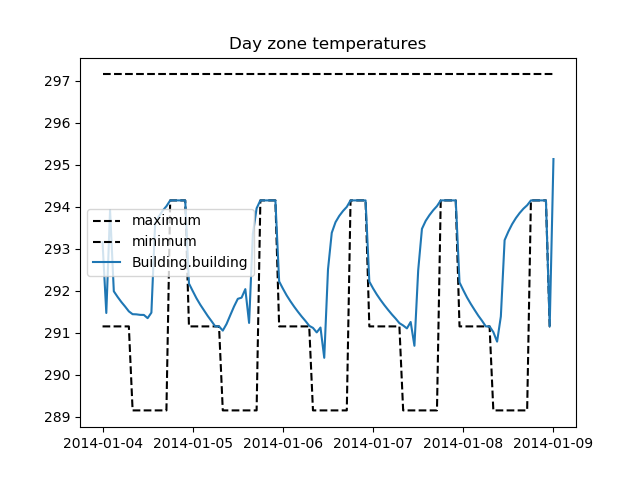

<IPython.core.display.Javascript object>


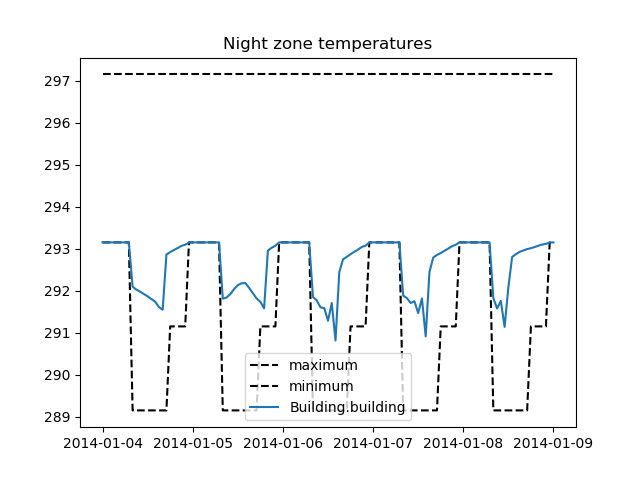

<IPython.core.display.Javascript object>


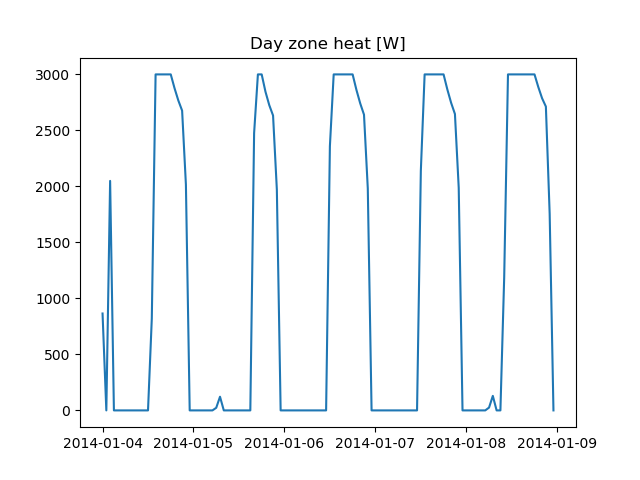

<IPython.core.display.Javascript object>


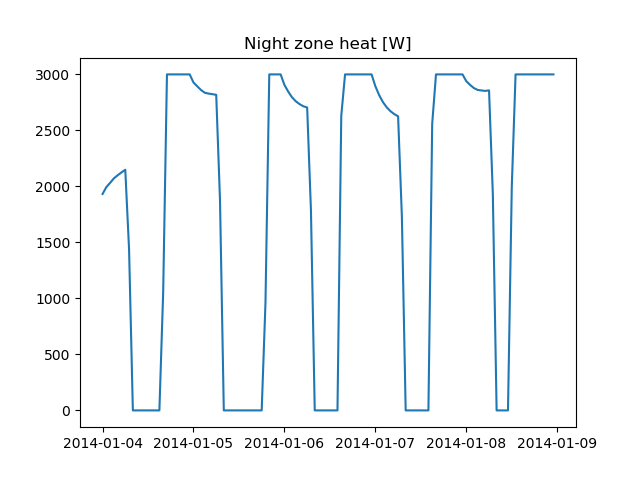

<IPython.core.display.Javascript object>


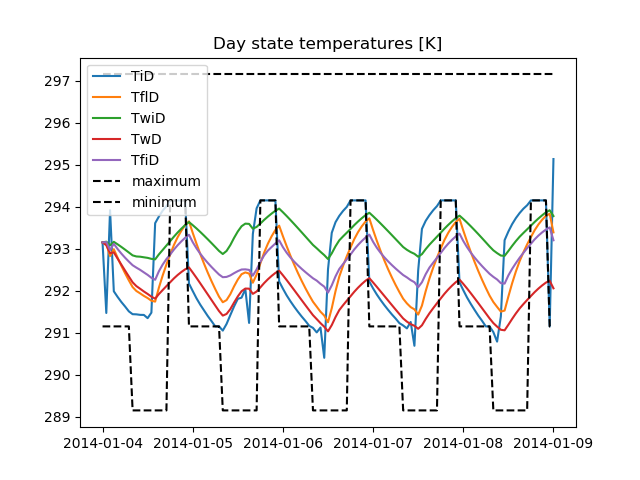

<IPython.core.display.Javascript object>


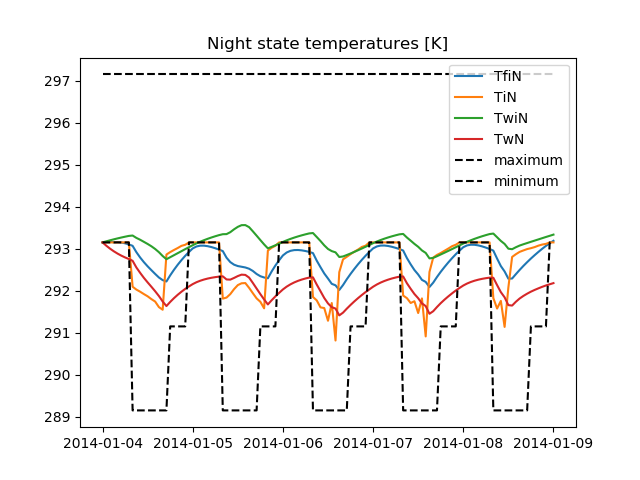

Text(0.5,1,u'Night state temperatures [K]')

In [25]:

day_max = ut.read_period_data('../Data/UserBehaviour', name='ISO13790.csv',
                              time_step=time_step, horizon=horizon, start_time=start_time)['day_max']
day_min = ut.read_period_data('../Data/UserBehaviour', name='ISO13790.csv',
                              time_step=time_step, horizon=horizon, start_time=start_time)['day_min']
night_max = ut.read_period_data('../Data/UserBehaviour', name='ISO13790.csv',
                                time_step=time_step, horizon=horizon, start_time=start_time)['night_max']
night_min = ut.read_period_data('../Data/UserBehaviour', name='ISO13790.csv',
                                time_step=time_step, horizon=horizon, start_time=start_time)['night_min']

fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
# ax1 = fig1.add_subplot(221)
ax1.plot(day_max, label='maximum', linestyle='--', color='k')
ax1.plot(day_min, label='minimum', linestyle='--', color='k')
ax1.plot(TiD, label='Building.building')
ax1.legend()
ax1.set_title('Day zone temperatures')

fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
ax2.plot(night_max, label='maximum', linestyle='--', color='k')
ax2.plot(night_min, label='minimum', linestyle='--', color='k')
ax2.plot(TiN, label='Building.building')
ax2.legend()
ax2.set_title('Night zone temperatures')

fig3 = plt.figure()
ax3 = fig3.add_subplot(111)
ax3.plot(Q_hea_D)
ax3.set_title('Day zone heat [W]')

fig4 = plt.figure()
ax4 = fig4.add_subplot(111)
ax4.plot(Q_hea_N)
ax4.set_title('Night zone heat [W]')

fig5 = plt.figure()
ax5 = fig5.add_subplot(111)
ax5.plot(TiD, label='TiD')
ax5.plot(TflD, label='TflD')
ax5.plot(TwiD, label='TwiD')
ax5.plot(TwD, label='TwD')
ax5.plot(TfiD, label='TfiD')
ax5.plot(day_max, label='maximum', linestyle='--', color='k')
ax5.plot(day_min, label='minimum', linestyle='--', color='k')
ax5.legend()
ax5.set_title('Day state temperatures [K]')

fig6 = plt.figure()
ax6 = fig6.add_subplot(111)
ax6.plot(TfiN, label='TfiN')
ax6.plot(TiN, label='TiN')
ax6.plot(TwiN, label='TwiN')
ax6.plot(TwN, label='TwN')
ax6.plot(night_max, label='maximum', linestyle='--', color='k')
ax6.plot(night_min, label='minimum', linestyle='--', color='k')
ax6.legend()
ax6.set_title('Night state temperatures [K]')



## Storage unit

In [26]:
storage_stored_heat = optmodel.get_result('heat_stor', node='BuildingAndStorage',
                                  comp='storage')
storage_heat_flow = optmodel.get_result('heat_flow', node='BuildingAndStorage',
                                 comp='storage')

<IPython.core.display.Javascript object>


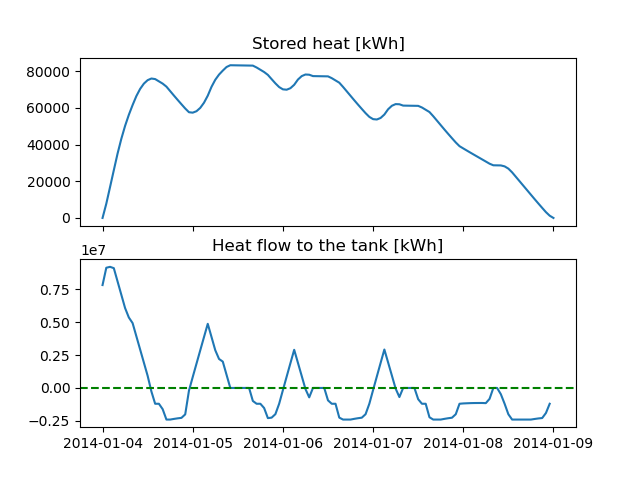

In [27]:
fig1, (ax, ax2) = plt.subplots(2,1, sharex=True)
ax.plot(storage_stored_heat)
ax.set_title('Stored heat [kWh]')
ax2.plot(storage_heat_flow)
ax2.set_title('Heat flow to the tank [kWh]')
ax2.axhline(linestyle='--', color='g')

## Heat generation unit

In [28]:
prod_hf = optmodel.get_result('heat_flow', node='Producer', comp='plant')
c_f = ut.read_period_data(path='../Data/ElectricityPrices',
                          name='DAM_electricity_prices-2014_BE.csv',
                          time_step=time_step, horizon=horizon,
                          start_time=start_time)['price_BE']

<IPython.core.display.Javascript object>


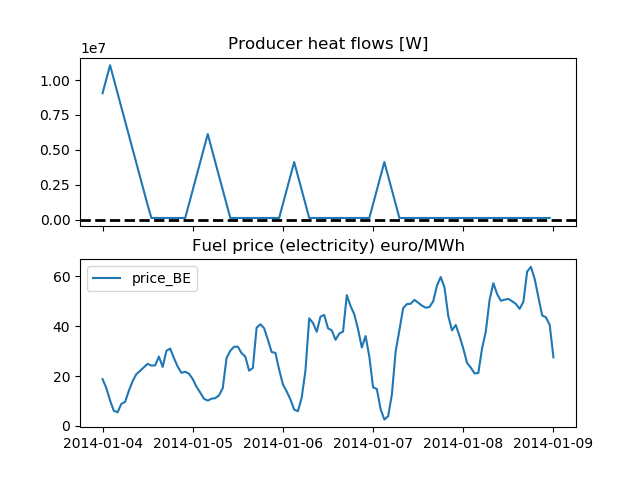

In [29]:
fig, (ax, ax1) = plt.subplots(2, 1 , sharex=True)
ax.plot(prod_hf)

ax.axhline(y=0, linewidth=2, color='k', linestyle='--')
ax.set_title('Producer heat flows [W]')

ax1.plot(c_f)
ax1.set_title('Fuel price (electricity) euro/MWh')
ax1.legend()
#fig.tight_layout()

The plot clearly shows that the cost objective is followed, with the heat generation unit preferring moments of low electricity price to inject heat into the network.

Looking at the plots of the storage unit, you can see that most of this heat is stored there and used at a later time to keep the buildings sufficiently warm.

## Network efficiency

In [30]:
# Heat flows
prod_hf = optmodel.get_result('heat_flow', node='Producer', comp='plant')
storage_hf = optmodel.get_result('heat_flow', node='BuildingAndStorage',
                                 comp='storage')
waterschei_hf = optmodel.get_result('heat_flow', node='BuildingAndStorage',
                                    comp='building')
zwartberg_hf = optmodel.get_result('heat_flow', node='Building',
                                   comp='building')


# Sum of heat flows
prod_e = sum(prod_hf)
storage_e = sum(storage_hf)
waterschei_e = sum(waterschei_hf)
zwartberg_e = sum(zwartberg_hf)

# Efficiency
print '\nNetwork efficiency', (storage_e + waterschei_e + zwartberg_e) / prod_e * 100, '%'
    


Network efficiency 90.5169127782 %
